In [1]:
# Remove input cells at runtime (nbsphinx)
import IPython.core.display as d
d.display_html('<script>jQuery(function() {if (jQuery("body.notebook_app").length == 0) { jQuery(".input_area").toggle(); jQuery(".prompt").toggle();}});</script>', raw=True)

# Particle classification (MODEL)

**Recommended datasample(s):** model file, train and test data produced with ``protopipe-MODEL``

**Data level(s):** DL1b (telescope-wise image parameters) + DL2 (shower geometry and estimated energy)

**Description:**

Test the performance of the trained model **before** use it to estimate the particle type of DL2 events.  
In a *protopipe* analysis part of the TRAINING sample is used for *testing* the models to get some preliminary diagnostics (i.e. before launching the much heavier DL2 production).  
Note that this notebook shows a camera-wise preliminary diagnostics (since one model is produced per-camera): this means that the model output considered here is the _telescope-wise_ quantity and not the _event-wise_ one which is instead benchmarked at a subsequent step.  
Settings and setup of the plots are done using the same configuration file used for training the model.

**Requirements and steps to reproduce:**

- produce the model with ``protopipe-MODEL``

- Execute the notebook ``protopipe-BENCHMARK``,

``protopipe-BENCHMARK launch --config_file configs/benchmarks.yaml -n TRAINING/benchmarks_MODELS_classification``

To obtain the list of all available parameters add ``--help-notebook``.

**Development and testing:**  

As with any other part of _protopipe_ and being part of the official repository, this notebook can be further developed by any interested contributor.   
The execution of this notebook is not currently automatic, it must be done locally by the user _before_ pushing a pull-request.  
Please, strip the output before pushing.

## Table of contents

* [Feature importance](#Feature-importance)
* [Feature distributions](#Feature-distributions)
* [Boosted Decision Tree Error rate](#Boosted-Decision-Tree-Error-rate)
* [Model output](#Model-output)
* [Energy-dependent distributions](#Energy-dependent-distributions)
* [Energy-dependent ROC curves](#ROC-curve-variation-on-test-sample)
* [AUC as a function of reconstructed energy](#AUC-as-a-function-of-reconstructed-energy)

## Imports
[back to top](#Table-of-contents)

In [2]:
import gzip
import glob
from pathlib import Path

import pickle
import joblib
import yaml
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
from sklearn.metrics import auc, roc_curve

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
plt.rcParams.update({'figure.max_open_warning': 0})

from protopipe.pipeline.io import load_config, load_obj

## Functions and classes
[back to top](#Table-of-contents)

In [3]:
def plot_hist(ax, data, nbin, limit, norm=False, yerr=False, hist_kwargs={}, error_kw={}):
    """Utility function to plot histogram"""
    bin_edges = np.linspace(limit[0], limit[-1], nbin + 1, True)
    y, tmp = np.histogram(data, bins=bin_edges)
    weights = np.ones_like(y)
    if norm is True:
        weights = weights / float(np.sum(y))
    if yerr is True:
        yerr = np.sqrt(y) * weights
    else:
        yerr = np.zeros(len(y))

    centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])
    width = bin_edges[1:] - bin_edges[:-1]
    ax.bar(centers, y * weights, width=width, yerr=yerr, error_kw=error_kw, **hist_kwargs)

    return ax

In [4]:
def plot_distributions(feature_list,
                       data_list,
                       nbin=30,
                       hist_kwargs_list={},
                       error_kw_list={},
                       ncols=2):
    """Plot feature distributions for several data set. Returns list of axes."""
    n_feature = len(feature_list)
    nrows = int(n_feature / ncols) if n_feature % ncols == 0 else round((n_feature + 1) / ncols)

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(5 * ncols,5 * nrows))
    if nrows == 1 and ncols == 1:
        axes = [axes]
    else:
        axes = axes.flatten()

    for i, colname in enumerate(feature_list):
        ax = axes[i]

        # Range for binning
        #range_min = min([data[colname].min() for data in data_list])
        #range_max = max([data[colname].max() for data in data_list])
        #myrange = [range_min, range_max]

        for j, data in enumerate(data_list):
            if colname in ["hillas_intensity", "h_max", "impact_dist"]: # automatically log these quantities for clarity
                # Range for binning
                range_min = min([np.log10(data[colname]).min() for data in data_list])
                range_max = max([np.log10(data[colname]).max() for data in data_list])
                myrange = [range_min, range_max]
        
                ax = plot_hist(
                    ax=ax, data=np.log10(data[colname]), nbin=nbin, limit=myrange,
                    norm=True, yerr=True,
                    hist_kwargs=hist_kwargs_list[j],
                    error_kw=error_kw_list[j]
                )
                ax.set_xlabel(f"log10({colname})")
            else:
                range_min = min([data[colname].min() for data in data_list])
                range_max = max([data[colname].max() for data in data_list])
                myrange = [range_min, range_max]
                
                ax = plot_hist(
                    ax=ax, data=data[colname], nbin=nbin, limit=myrange,
                    norm=True, yerr=True,
                    hist_kwargs=hist_kwargs_list[j],
                    error_kw=error_kw_list[j]
                )

                ax.set_xlabel(colname)

        ax.set_ylabel('Arbitrary units')
        ax.legend()
        ax.grid()

    return fig, axes

In [5]:
def plot_roc_curve(ax, model_output, y, **kwargs):
    """Plot ROC curve for a given set of model outputs and labels"""
    fpr, tpr, _ = roc_curve(y_score=model_output, y_true=y)
    roc_auc = auc(fpr, tpr)
    label = '{} (area={:.2f})'.format(kwargs.pop('label'), roc_auc)  # Remove label
    ax.plot(fpr, tpr, label=label, **kwargs)
    return ax

In [6]:
def get_evt_subarray_model_output(data,
                                  weight_name=None,
                                  keep_cols=['reco_energy'],
                                  model_output_name='score_img',
                                  model_output_name_evt='score'):
    """
    Returns DataStore with keepcols + score/target columns of model at the
    level-subarray-event.
    
    Parameters
    ----------
    data: `~pandas.DataFrame`
        Data frame
    weight_name: `str`
        Variable name in data frame to weight events with
    keep_cols: `list`, optional
        List of variables to keep in resulting data frame
    model_output_name: `str`, optional
        Name of model output (image level)
    model_output_name_evt: `str`, optional
        Name of averaged model output (event level)
    
    Returns
    --------
    data: `~pandas.DataFrame`
        Data frame
    """

    keep_cols += [model_output_name]
    keep_cols += [weight_name]
    new_data = data[keep_cols].copy(deep=True)

    new_data[model_output_name_evt] = np.zeros(len(new_data))
    new_data.set_index(["tel_id"], append=True, inplace=True)

    new_data[model_output_name_evt] = new_data.groupby(["obs_id", "event_id"]).apply(
        lambda g: np.average(g[model_output_name], weights=g[weight_name])
    )

    # Remove columns
    new_data = new_data.drop(columns=[model_output_name])

    # Remove duplicates
    new_data = new_data[~new_data.index.duplicated(keep="first")]

    return new_data

In [7]:
class ModelDiagnostic(object):
    """
    Base class for model diagnostics.
    
    Parameters
    ----------
    model: `~sklearn.base.BaseEstimator`
        Best model
    feature_name_list: list
        List of the features used to buil the model
    target_name: str
        Name of the target (e.g. score, gamaness, energy, etc.)
    """
    def __init__(self, model, feature_name_list, target_name):
        self.model = model
        self.feature_name_list = feature_name_list
        self.target_name = target_name

    def plot_feature_importance(self, ax, **kwargs):
        """
        Plot importance of features
        Parameters
        ----------
        ax: `~matplotlib.axes.Axes`
            Axis
        """
        if ax is None:
            import matplotlib.pyplot as plt
            ax = plt.gca()

        importance = self.model.feature_importances_
        importance, feature_labels = \
            zip(*sorted(zip(importance, self.feature_name_list), reverse=True))

        bin_edges = np.arange(0, len(importance)+1)
        bin_width = bin_edges[1:] - bin_edges[:-1] - 0.1

        ax.bar(bin_edges[:-1], importance, width=bin_width, **kwargs)
        ax.set_xticks(np.arange(0, len(importance)))
        ax.set_xticklabels(feature_labels, rotation=75)

        return ax

    def plot_features(self, data_list,
                      nbin=30,
                      hist_kwargs_list={},
                      error_kw_list={},
                      ncols=2):
        """
        Plot model features for different data set (e.g. training and test samples).
        Parameters
        ----------
        data_list: list
            List of data
        nbin: int
            Number of bin
        hist_kwargs_list: dict
            Dictionary with histogram options
        error_kw_list: dict
            Dictionary with error bar options
        ncols: int
            Number of columns
        """
        return plot_distributions(
            self.feature_name_list,
            data_list,
            nbin,
            hist_kwargs_list,
            error_kw_list, ncols
        )

    def add_image_model_output(self):
        raise NotImplementedError("Please Implement this method")

In [8]:
class ClassifierDiagnostic(ModelDiagnostic):
    """
    Class to plot several diagnostic plot for classification. Assume that positives and
    negatives are respectively labeled as 1 and 0.
    Parameters
    ----------
    model: sklearn.base.BaseEstimator
        Scikit model
    feature_name_list: list
        List of features
    model_output_name: str
        Name of output
    is_output_proba: bool
        If false, `decision_function` will be called, otherwise, predict_proba.
        In the last case we only consider the probability for signal event
    """
    def __init__(self, model, feature_name_list, target_name,
                 data_train, data_test, model_output_name='score', is_output_proba=False):
        super().__init__(model, feature_name_list, target_name)

        self.data_train = data_train
        self.data_test = data_test
        self.model_output_name = model_output_name
        self.is_output_proba = is_output_proba

        # Compute and add model output
        self.data_train = self.add_image_model_output(
            self.data_train,
            col_name=self.model_output_name
        )
        self.data_test = self.add_image_model_output(
            self.data_test,
            col_name=self.model_output_name
        )

    def add_image_model_output(self, data, col_name):
        """Add model output column"""
        if self.is_output_proba is False:
            data[col_name] = self.model.decision_function(data[self.feature_name_list])
        else:  # Interested in signal probability
            data[col_name] = self.model.predict_proba(data[self.feature_name_list])[:,1]
        return data

    def plot_image_model_output_distribution(
            self,
            cut=None,
            nbin=30,
            hist_kwargs_list=[
                {'edgecolor': 'blue', 'color': 'blue', 'label': 'Gamma training sample',
                'alpha': 0.2, 'fill': True, 'ls': '-', 'lw': 2},
                {'edgecolor': 'blue', 'color': 'blue', 'label': 'Gamma test sample',
                'alpha': 1, 'fill': False, 'ls': '--', 'lw': 2},
                {'edgecolor': 'red', 'color': 'red', 'label': 'Proton training sample',
                'alpha': 0.2, 'fill': True, 'ls': '-', 'lw': 2},
                {'edgecolor': 'red', 'color': 'red', 'label': 'Proton test sample',
                'alpha': 1, 'fill': False, 'ls': '--', 'lw': 2}
            ],
            error_kw_list=[
                dict(ecolor='blue', lw=2, capsize=3, capthick=2, alpha=0.2),
                dict(ecolor='blue', lw=2, capsize=3, capthick=2, alpha=1),
                dict(ecolor='red', lw=2, capsize=3, capthick=2, alpha=0.2),
                dict(ecolor='red', lw=2, capsize=3, capthick=2, alpha=1)
                ]
    ):
        """Plot output distribution. Need more output column"""
        if cut is not None:
            data_test = self.data_test.query(cut)
            data_train = self.data_train.query(cut)
        else:
            data_test = self.data_test
            data_train = self.data_train

        return plot_distributions(
            [self.model_output_name],
            [data_train.query('label==1'), data_test.query('label==1'),
             data_train.query('label==0'), data_test.query('label==0')],
            nbin,
            hist_kwargs_list,
            error_kw_list,
            1
        )

In [9]:
class BoostedDecisionTreeDiagnostic(object):
    """
    Class producing diagnostic plot for the BDT method
    """

    @classmethod
    def plot_error_rate(cls, ax, model, data_scikit, **kwargs):
        """Diagnostic plot showing error rate as a function of the specialisation"""
        import matplotlib.pyplot as plt

        if ax is None:
            ax = plt.gca()

        test_errors = []
        for test_predict in model.staged_predict(data_scikit["X_test"]):
            test_errors.append(
                1.0 - accuracy_score(test_predict, data_scikit["y_test"])
            )

        ntrees = len(model)
        ax.plot(range(1, ntrees + 1), test_errors, **kwargs)
        ax.set_xlabel("Number of Trees")
        ax.set_ylabel("Error rate")
        ax.grid()
        plt.tight_layout()
        return ax

    @classmethod
    def plot_tree_error_rate(cls, ax, model, **kwargs):
        """Diagnostic plot showing tree error rate"""
        import matplotlib.pyplot as plt

        if ax is None:
            ax = plt.gca()

        ntrees = len(model)
        estimator_errors = model.estimator_errors_[:ntrees]

        ntrees = len(model)
        ax.plot(range(1, ntrees + 1), estimator_errors, **kwargs)
        ax.set_xlabel("Tree number")
        ax.set_ylabel("Error rate / tree")
        ax.grid()
        plt.tight_layout()
        return ax

## Load models
[back to top](#Table-of-contents)

In [10]:
analyses_directory = None
analysis_name = None
model_configuration_filename = None # Name of the configuration file of the model
output_directory = Path.cwd() # default output directory for plots

In [11]:
# Parameters
analyses_directory = "/Users/michele/Applications/ctasoft/dirac/shared_folder/analyses"
analysis_name = "v0.5.0a1"
analysis_name_2 = "v0.4.0_dev1"
use_seaborn = True
seaborn_settings = {
    "style": "whitegrid",
    "context": "talk",
    "rc": {"xtick.bottom": True, "ytick.left": True},
}
load_requirements = True
requirements_input_directory = "/Volumes/DataCEA_PERESANO/Data/CTA/requirements/"
load_CTAMARS = True
input_data_CTAMARS = {
    "parent_directory": "/Users/michele/Applications/ctasoft/tests/CTAMARS_reference_data",
    "TRAINING/DL1": "TRAINING/DL1",
    "TRAINING/DL2": "TRAINING/DL2",
    "DL2": "",
    "DL3": {
        "input_directory": "DL3",
        "input_file": "SubarrayLaPalma_4L15M_south_IFAE_50hours_20190630.root",
    },
    "label": "CTAMARS (2019)",
}
load_EventDisplay = True
input_data_EventDisplay = {
    "input_directory": "/Volumes/DataCEA_PERESANO/Data/CTA/ASWG/Prod3b/Release_2018-12-03/ROOT/North/CTA-Performance-North-20deg_20181203",
    "input_file": "CTA-Performance-North-20deg-S-50h_20181203.root",
    "label": "EventDisplay (2018)",
}
input_filenames = {
    "simtel": "/Users/michele/Applications/ctasoft/tests/data/simtel/gamma_20deg_180deg_run100___cta-prod3-demo-2147m-LaPalma-baseline.simtel.gz",
    "TRAINING_energy_gamma": "TRAINING_energy_tail_gamma_merged.h5",
    "TRAINING_classification_gamma": "TRAINING_classification_tail_gamma_merged.h5",
    "DL2_gamma": "DL2_tail_gamma_merged.h5",
    "DL2_proton": "DL2_energy_tail_gamma_merged.h5",
    "DL2_electron": "DL2_energy_tail_gamma_merged.h5",
    "DL3": "performance_protopipe_Prod3b_CTANorth_baseline_full_array_Zd20deg_180deg_Time50.00h.fits.gz",
}
model_configuration_filenames = {
    "energy": "RandomForestRegressor.yaml",
    "classification": "RandomForestClassifier.yaml",
}
input_filenames_ctapipe = {
    "DL1a_gamma": "events_protopipe_CTAMARS_calibration_1stPass.dl1.h5",
    "DL1a_gamma_2ndPass": "events_protopipe_CTAMARS_calibration_2ndPass.dl1.h5",
}
output_directory = "/Users/michele/Applications/ctasoft/dirac/shared_folder/analyses/v0.5.0a1/benchmarks_results/MODELS"


In [12]:
# Check that the model configuration file has been defined
# either from the CLI of from the benchmarks configuration file (default)
if model_configuration_filename is None:
    try:
        model_configuration_filename = model_configuration_filenames["classification"]
    except KeyError:
        raise ValueError("The name of the configuration file is undefined.")

In [13]:
analysis_configuration_path = Path(analyses_directory) / analysis_name / Path("configs/analysis.yaml")
model_configuration_path = Path(analyses_directory) / analysis_name / "configs" / model_configuration_filename
input_directory = Path(analyses_directory) / analysis_name / Path("estimators/gamma_hadron_classifier")

In [14]:
# Load configuration files
ana_cfg = load_config(analysis_configuration_path)
cfg = load_config(model_configuration_path)

# Get info from configs
model_type = "classifier"
method_name = cfg["Method"]["name"].split(".")[-1]

In [15]:
cameras = [model.split('/')[-1].split('_')[1] for model in glob.glob(f"{input_directory}/{model_type}*.pkl.gz")]
data = {camera : dict.fromkeys(["model", "data_scikit", "data_train", "data_test"]) for camera in cameras} 

for camera in cameras:

    data[camera]["data_scikit"] = load_obj(
                glob.glob(f"{input_directory}/data_scikit_{model_type}_{method_name}_{camera}.pkl.gz")[0]
                )
    data[camera]["data_train"] = pd.read_pickle(
        glob.glob(f"{input_directory}/data_train_{model_type}_{method_name}_{camera}.pkl.gz")[0]
                )
    data[camera]["data_test"] = pd.read_pickle(
        glob.glob(f"{input_directory}/data_test_{model_type}_{method_name}_{camera}.pkl.gz")[0]
    )
    
    modelName = f"{model_type}_{camera}_{method_name}.pkl.gz"
    data[camera]["model"] = joblib.load(glob.glob(f"{input_directory}/{model_type}_{camera}_{method_name}.pkl.gz")[0])

## Settings and setup
[back to top](#Table-of-contents)

In [16]:
try:
    if cfg["Method"]["use_proba"] is True:
        output_model_name = "gammaness"
    else:
        output_model_name = "score"
except KeyError:
    output_model_name = "gammaness"

In [17]:
# Energy (both true and reconstructed) [TeV]
nbins = cfg["Diagnostic"]["energy"]["nbins"]

energy_edges = np.logspace(
        np.log10(cfg["Diagnostic"]["energy"]["min"]),
        np.log10(cfg["Diagnostic"]["energy"]["max"]),
        nbins + 1,
        True,
    )

In [18]:
# Parameters for energy variation
cut_list = [
    "reco_energy >= {:.2f} and reco_energy <= {:.2f}".format(
        energy_edges[i], energy_edges[i + 1]
    )
    for i in range(len(energy_edges) - 1)
]

In [19]:
features_basic = cfg["FeatureList"]["Basic"]
features_derived = cfg["FeatureList"]["Derived"]
features = features_basic + list(features_derived)
features = sorted(features)

In [20]:
diagnostic = dict.fromkeys(cameras)
for camera in cameras:   
    diagnostic[camera] = ClassifierDiagnostic(
                            model=data[camera]["model"],
                            feature_name_list=features,
                            target_name=cfg["Method"]["target_name"],
                            data_train=data[camera]["data_train"],
                            data_test=data[camera]["data_test"],
                            model_output_name=output_model_name,
                            is_output_proba=cfg["Method"]["use_proba"])

## Benchmarks
[back to top](#Table-of-contents)

### Feature importance
[back to top](#Table-of-contents)

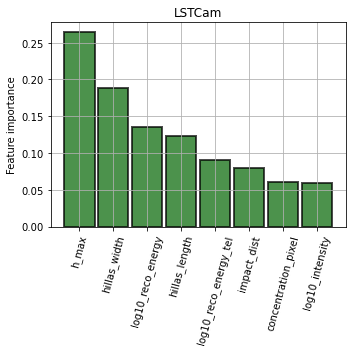

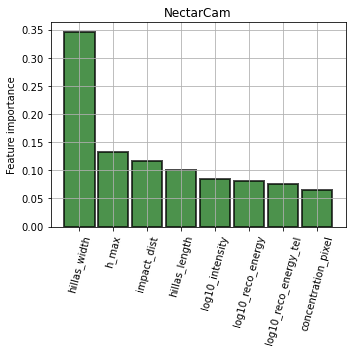

In [21]:
for camera in cameras:
    plt.figure(figsize=(5, 5))
    ax = plt.gca()
    ax = diagnostic[camera].plot_feature_importance(
        ax,
        **{"alpha": 0.7, "edgecolor": "black", "linewidth": 2, "color": "darkgreen"}
    )
    ax.set_ylabel("Feature importance")
    ax.grid()
    plt.title(camera)
    plt.tight_layout()

### Feature distributions
[back to top](#Table-of-contents)

**Note:** quantities like ``h_max`` and ``impact_dist`` are automatically shown as ``log10`` for these plots for better clarity.

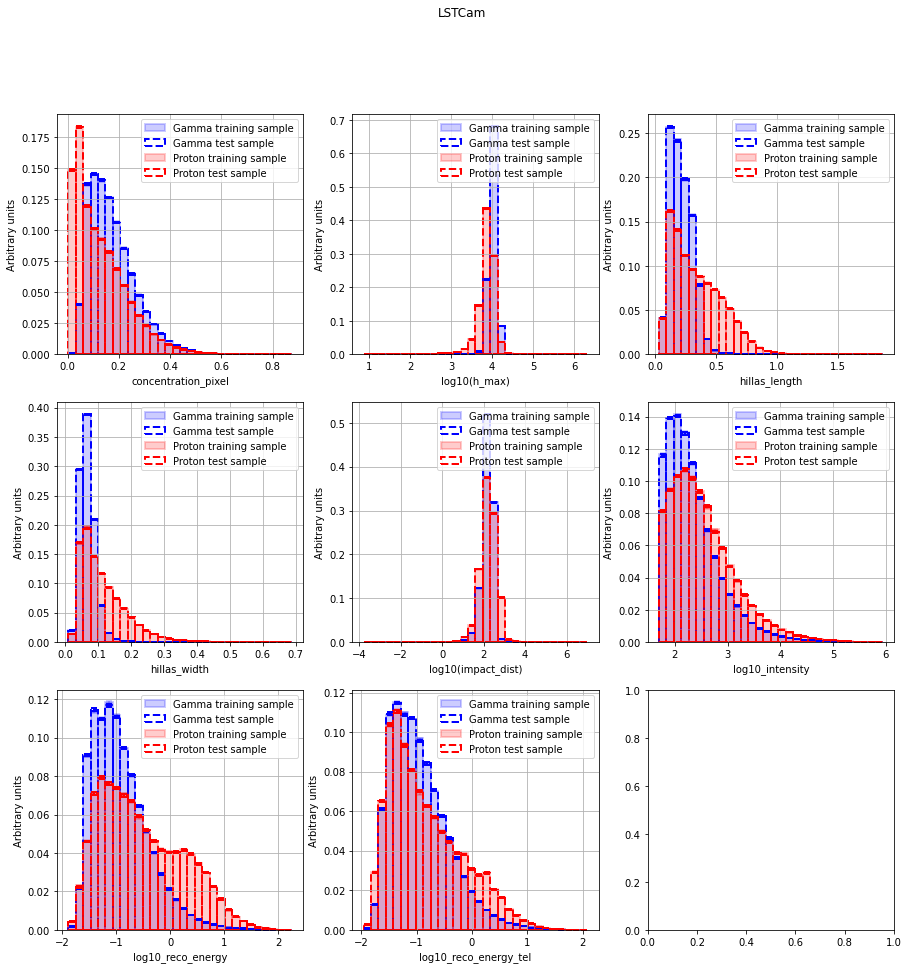

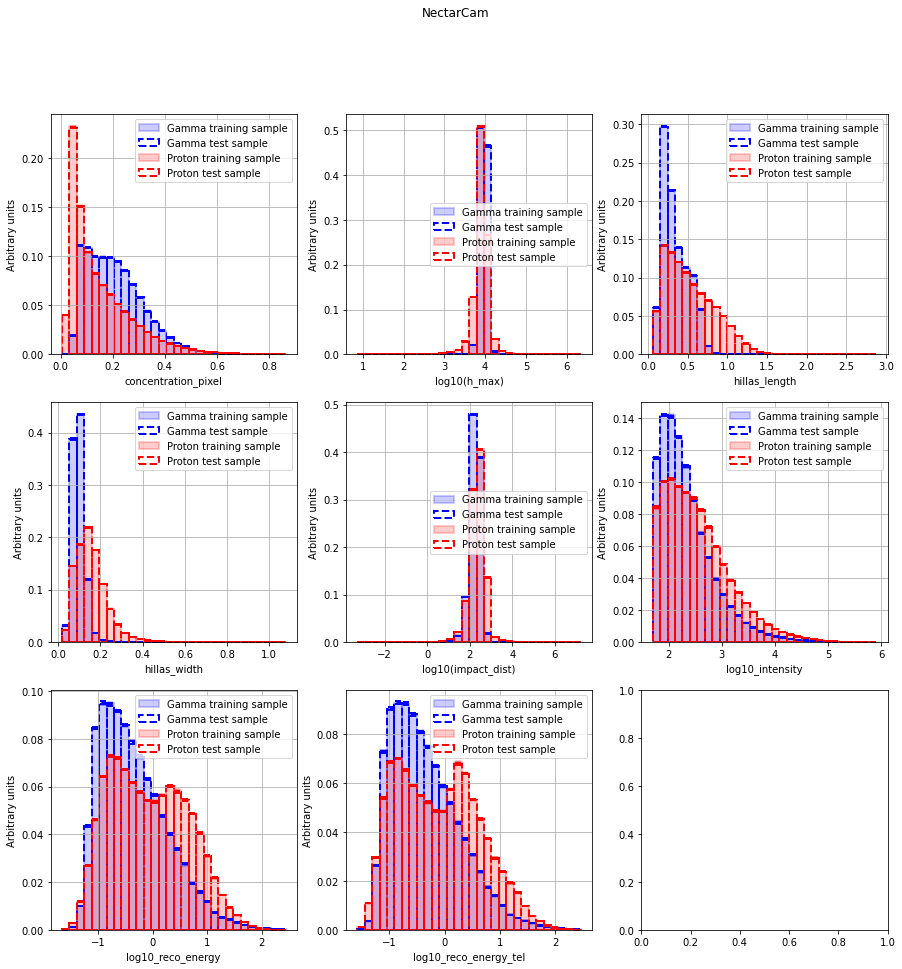

In [22]:
for camera in cameras:
    
    fig, axes = diagnostic[camera].plot_features(
                data_list=[
                    data[camera]["data_train"].query("label==1"),
                    data[camera]["data_test"].query("label==1"),
                    data[camera]["data_train"].query("label==0"),
                    data[camera]["data_test"].query("label==0"),
                ],
                nbin=30,
                hist_kwargs_list=[
                    {
                        "edgecolor": "blue",
                        "color": "blue",
                        "label": "Gamma training sample",
                        "alpha": 0.2,
                        "fill": True,
                        "ls": "-",
                        "lw": 2,
                    },
                    {
                        "edgecolor": "blue",
                        "color": "blue",
                        "label": "Gamma test sample",
                        "alpha": 1,
                        "fill": False,
                        "ls": "--",
                        "lw": 2,
                    },
                    {
                        "edgecolor": "red",
                        "color": "red",
                        "label": "Proton training sample",
                        "alpha": 0.2,
                        "fill": True,
                        "ls": "-",
                        "lw": 2,
                    },
                    {
                        "edgecolor": "red",
                        "color": "red",
                        "label": "Proton test sample",
                        "alpha": 1,
                        "fill": False,
                        "ls": "--",
                        "lw": 2,
                    },
                ],
                error_kw_list=[
                    dict(ecolor="blue", lw=2, capsize=3, capthick=2, alpha=0.2),
                    dict(ecolor="blue", lw=2, capsize=3, capthick=2, alpha=1),
                    dict(ecolor="red", lw=2, capsize=3, capthick=2, alpha=0.2),
                    dict(ecolor="red", lw=2, capsize=3, capthick=2, alpha=1),
                ],
                ncols=3,
            )
    plt.suptitle(camera)
    plt.show()

### Boosted Decision Tree Error rate
[back to top](#Table-of-contents)

In [23]:
if method_name != "AdaBoostClassifier":
    
    print("The model is not an AdaBoostClassifier")

else:
    
    for camera in cameras:
        plt.figure(figsize=(5, 5))
        ax = plt.gca()
        opt = {"color": "darkgreen", "ls": "-", "lw": 2}
        BoostedDecisionTreeDiagnostic.plot_error_rate(
            ax, model, data_scikit, **opt
        )
        plt.title(camera)
        plt.tight_layout()

        plt.figure(figsize=(5, 5))
        ax = plt.gca()
        BoostedDecisionTreeDiagnostic.plot_tree_error_rate(ax, model, **opt)
        plt.title(camera)
        plt.show()

The model is not an AdaBoostClassifier


### Model output
[back to top](#Table-of-contents)

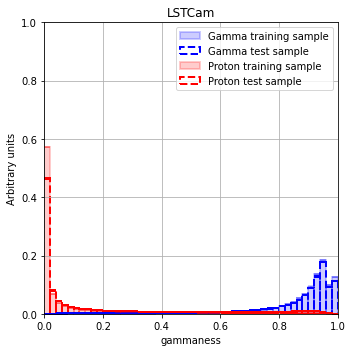

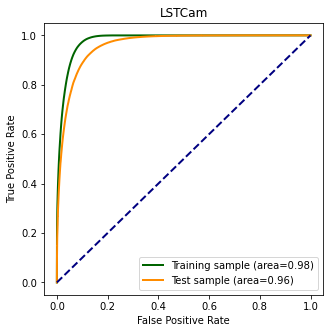

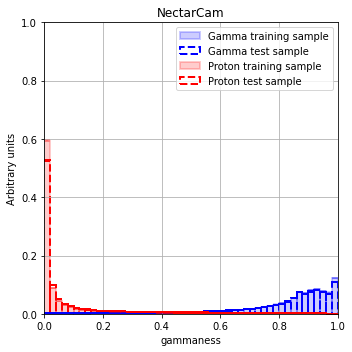

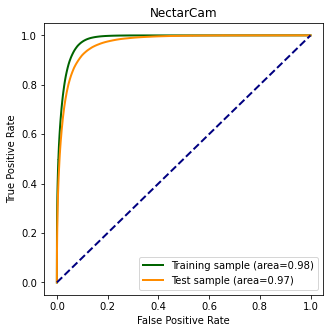

In [24]:
for camera in cameras:

    fig, ax = diagnostic[camera].plot_image_model_output_distribution(nbin=50)
    ax[0].set_xlim([0, 1])
    ax[0].set_ylim([0, 1])
    plt.title(camera)
    fig.tight_layout()

    plt.figure(figsize=(5, 5))
    ax = plt.gca()
    plot_roc_curve(
        ax,
        diagnostic[camera].data_train[diagnostic[camera].model_output_name],
        diagnostic[camera].data_train[cfg["Method"]["target_name"]],
        **dict(color="darkgreen", lw=2, label="Training sample")
    )
    plot_roc_curve(
        ax,
        data[camera]["data_test"][diagnostic[camera].model_output_name],
        diagnostic[camera].data_test[cfg["Method"]["target_name"]],
        **dict(color="darkorange", lw=2, label="Test sample")
    )
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    ax.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
    ax.legend(loc="lower right")
    plt.title(camera)
    plt.show()

## Energy-dependent distributions
[back to top](#Table-of-contents)

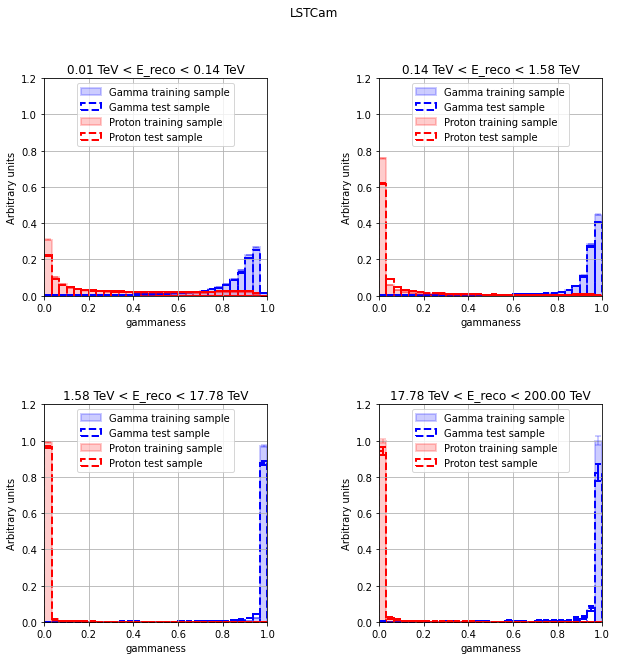

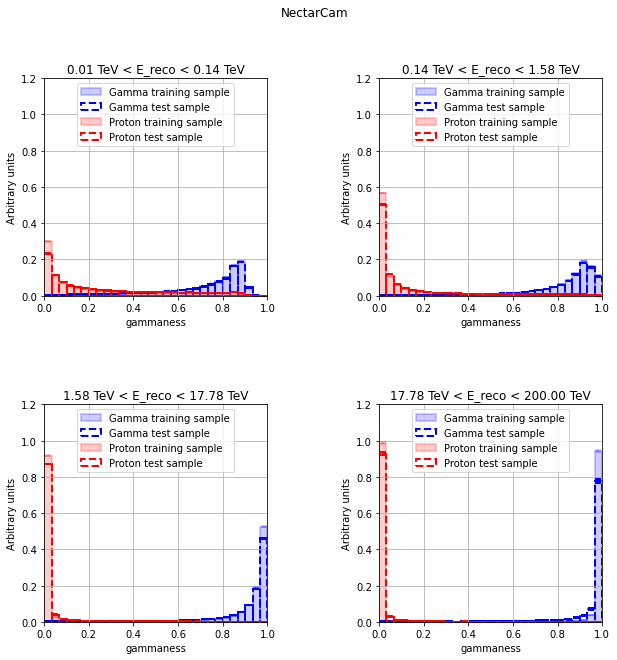

In [25]:
hist_kwargs_list = [
    {
        "edgecolor": "blue",
        "color": "blue",
        "label": "Gamma training sample",
        "alpha": 0.2,
        "fill": True,
        "ls": "-",
        "lw": 2,
    },
    {
        "edgecolor": "blue",
        "color": "blue",
        "label": "Gamma test sample",
        "alpha": 1,
        "fill": False,
        "ls": "--",
        "lw": 2,
    },
    {
        "edgecolor": "red",
        "color": "red",
        "label": "Proton training sample",
        "alpha": 0.2,
        "fill": True,
        "ls": "-",
        "lw": 2,
    },
    {
        "edgecolor": "red",
        "color": "red",
        "label": "Proton test sample",
        "alpha": 1,
        "fill": False,
        "ls": "--",
        "lw": 2,
    },
]

error_kw_list = [
    dict(ecolor="blue", lw=2, capsize=3, capthick=2, alpha=0.2),
    dict(ecolor="blue", lw=2, capsize=3, capthick=2, alpha=1),
    dict(ecolor="red", lw=2, capsize=3, capthick=2, alpha=0.2),
    dict(ecolor="red", lw=2, capsize=3, capthick=2, alpha=1),
]

n_feature = len(cut_list)
ncols = 2
nrows = (
    int(n_feature / ncols)
    if n_feature % ncols == 0
    else int((n_feature + 1) / ncols)
)

for camera in cameras:

    fig, axes = plt.subplots(
        nrows=nrows, ncols=ncols, figsize=(5 * ncols, 5 * nrows)
    )
    plt.subplots_adjust(hspace=0.5, wspace=0.5)
    if nrows == 1 and ncols == 1:
        axes = [axes]
    else:
        axes = axes.flatten()

    data_list = [
        data[camera]["data_train"].query("label==1"),
        data[camera]["data_test"].query("label==1"),
        data[camera]["data_train"].query("label==0"),
        data[camera]["data_test"].query("label==0"),
    ]

    for i, colname in enumerate(cut_list):
        ax = axes[i]

        # Range for binning
        the_range = [0, 1]

        for j, d in enumerate(data_list):
            if len(d) == 0:
                continue

            ax = plot_hist(
                ax=ax,
                data=d.query(cut_list[i])[output_model_name],
                nbin=30,
                limit=the_range,
                norm=True,
                yerr=True,
                hist_kwargs=hist_kwargs_list[j],
                error_kw=error_kw_list[j],
            )

        ax.set_xlim(the_range)
        ax.set_ylim(0,1.2)
        ax.set_xlabel(output_model_name)
        ax.set_ylabel("Arbitrary units")
        #ax.legend(loc="best", fontsize="small")
        ax.legend(loc="upper center")
        ax.set_title(f"{energy_edges[i]:.2f} TeV < E_reco < {energy_edges[i+1]:.2f} TeV")
        ax.grid()

    plt.suptitle(camera)

## ROC curve variation on test sample
[back to top](#Table-of-contents)

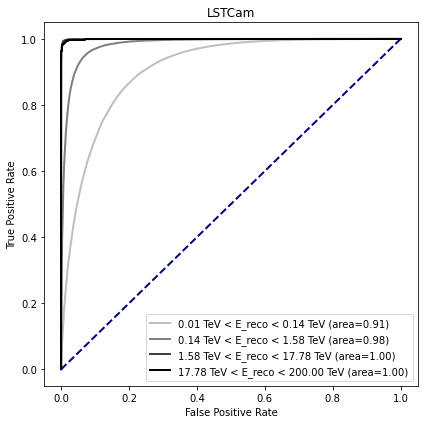

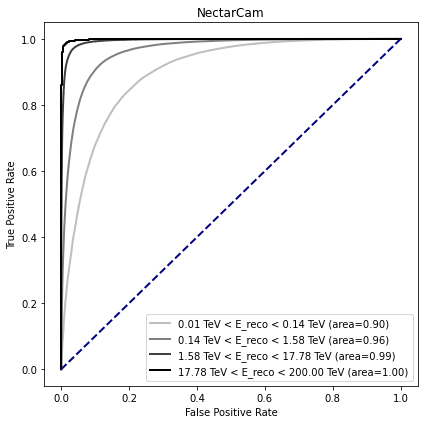

In [26]:
for camera in cameras:
    
    plt.figure(figsize=(6,6))
    ax = plt.gca()

    color = 1.0
    step_color = 1.0 / (len(cut_list))
    for i, cut in enumerate(cut_list):
        c = color - (i + 1) * step_color

        test_data = data[camera]["data_test"].query(cut)
        if len(test_data) == 0:
            continue

        opt = dict(
            color=str(c),
            lw=2,
            #label="{}".format(cut.replace("reco_energy", "E")),
            label=f"{energy_edges[i]:.2f} TeV < E_reco < {energy_edges[i+1]:.2f} TeV"
        )
        plot_roc_curve(ax, test_data[output_model_name], test_data[cfg["Method"]["target_name"]], **opt)
    ax.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
    ax.set_title(camera)
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    ax.legend(loc="lower right")
    plt.tight_layout()

## AUC as a function of reconstructed energy
[back to top](#Table-of-contents)

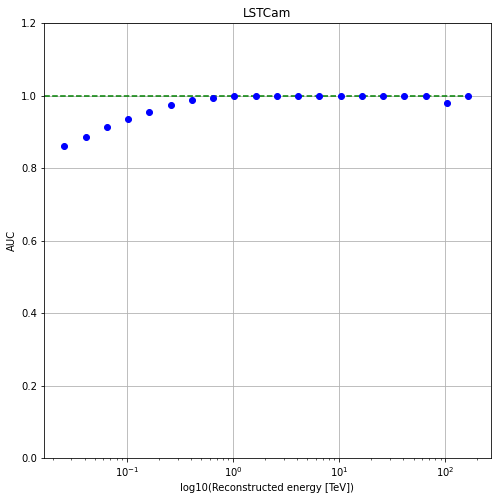

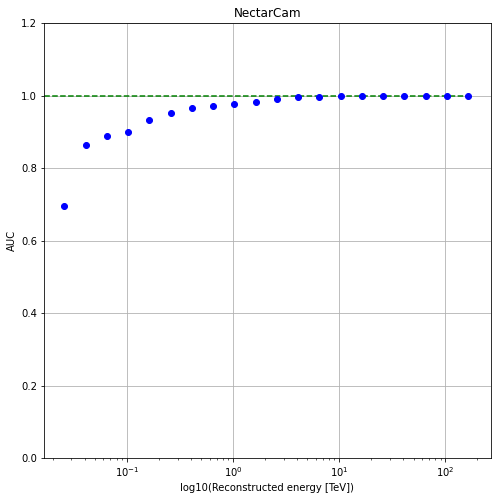

In [27]:
finer_energy_edges = np.logspace(
        np.log10(0.02),
        np.log10(200),
        21,
        True,
    )

cut_list_with_finer_energy_edges = [
    "reco_energy >= {:.2f} and reco_energy <= {:.2f}".format(
        finer_energy_edges[i], finer_energy_edges[i + 1]
    )
    for i in range(len(finer_energy_edges) - 1)
]

for camera in cameras:
    plt.figure(figsize=(8,8))
    plt.title(camera)
    
    aucs = []
    reco_energy = []
    
    for i, cut in enumerate(cut_list_with_finer_energy_edges):
    
        selected_images = data[camera]["data_test"].query(cut)
    
        fpr, tpr, _ = roc_curve(y_score=selected_images[output_model_name], y_true=selected_images[cfg["Method"]["target_name"]])
        roc_auc = auc(fpr, tpr)
        
        aucs.append(roc_auc)
        reco_energy.append( 0.5 * (finer_energy_edges[i] + finer_energy_edges[i+1]) )

    plt.plot(reco_energy, aucs, "bo")
    plt.hlines(1, xmin=plt.gca().get_xlim()[0], xmax=plt.gca().get_xlim()[1], linestyles="dashed", color="green")
    plt.ylim(0,1.2)
    plt.xscale("log")
    plt.xlabel("log10(Reconstructed energy [TeV])")
    plt.ylabel("AUC")
    plt.grid()

## Precision-Recall
[back to top](#Table-of-contents)

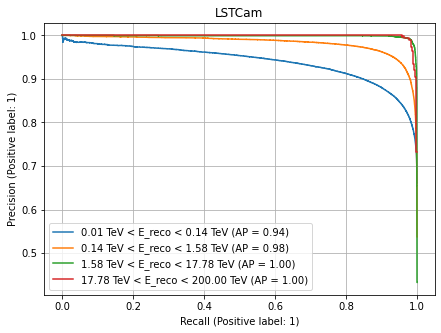

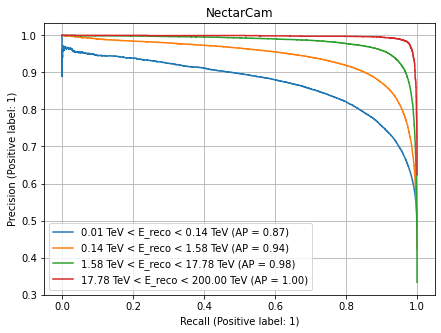

In [28]:
from sklearn.metrics import plot_precision_recall_curve

try:
    if cfg["Method"]["use_proba"] is True:
        response_method = "predict_proba"
    else:
        response_method = "decision_function"
except KeyError:
    response_method = "predict_proba"

for camera in cameras:
    
    plt.figure(figsize=(7, 5))
    plt.grid()
    plt.title(camera)
    
    for i, cut in enumerate(cut_list):
        c = color - (i + 1) * step_color

        selected_test_data = diagnostic[camera].data_test.query(cut)
        if len(test_data) == 0:
            continue

        opt = dict(
            color=str(c),
            lw=2,
            label=f"{energy_edges[i]:.2f} TeV < E_reco < {energy_edges[i+1]:.2f} TeV"
        )

        plot_precision_recall_curve(diagnostic[camera].model, 
                                    selected_test_data[features],
                                    selected_test_data[cfg["Method"]["target_name"]],
                                    response_method=response_method,
                                    ax=plt.gca(),
                                    name=opt["label"])
    